### Import Libraries

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

The BigQuery client will be used to send and receive messages from the BigQuery API

In [123]:
from google.cloud import bigquery
client = bigquery.Client()

Using a query, we save the table as a dataframe through the BigQuery Client

In [124]:
sql = """
SELECT  * FROM `thematic-flash-266714.australia_weather.weather`
"""
df = client.query(sql).to_dataframe()

In [125]:
df_copy = df.copy()

In [126]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-16,Albury,9.8,27.7,None,None,None,WNW,50,None,...,28,1013.4,1010.3,0,None,17.3,26.2,None,0.0,False
1,2009-02-04,Albury,21.7,36.9,0,None,None,None,None,None,...,26,1008.8,1004.7,None,None,25.5,35.2,No,0.0,False
2,2009-02-27,Albury,15.4,32.6,0,None,None,W,24,None,...,25,1016.2,1012.6,None,None,20,30.8,No,0.0,False
3,2009-03-06,Albury,7.6,24,0,None,None,WSW,30,None,...,23,1014.5,1012,None,None,12.6,22,No,0.0,False
4,2009-03-13,Albury,17.1,25.8,5.8,None,None,ENE,31,None,...,68,1017.4,1014.7,8,None,19,23.8,Yes,3.0,True


### Summary of Dataset

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  object 
 3   MaxTemp        141871 non-null  object 
 4   Rainfall       140787 non-null  object 
 5   Evaporation    81350 non-null   object 
 6   Sunshine       74377 non-null   object 
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  object 
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  object 
 12  WindSpeed3pm   139563 non-null  object 
 13  Humidity9am    140419 non-null  object 
 14  Humidity3pm    138583 non-null  object 
 15  Pressure9am    128179 non-null  object 
 16  Pressure3pm    128212 non-null  object 
 17  Cloud9am       88536 non-null

### Data Preprocessing

We can see that the datatype of few columns is incorrect. So we need to convert them.

In [128]:
convert_dict = {'MinTemp': 'float64','MaxTemp': 'float64','Rainfall': 'float64','Evaporation': 'float64',
'Sunshine': 'float64','WindGustSpeed': 'float64','WindSpeed9am': 'float64','WindSpeed3pm': 'float64',
'Humidity9am': 'float64','Humidity3pm': 'float64','Pressure9am': 'float64','Pressure3pm': 'float64',
'Cloud9am': 'float64','Cloud3pm': 'float64','Temp9am': 'float64','Temp3pm': 'float64'}

df = df.astype(convert_dict)

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

**Comments**

From the above information we can gather that

- The dataset is a mixture of numerical and categorical values
- The datatype of categorical values is **object**
- The datatype of numerical values is **float64**
- The target variable RainTomorrow is a **boolean**

#### Check for Null Values

In [130]:
df.isnull().sum().sort_values(ascending=False)

Sunshine         67816
Evaporation      60843
Cloud3pm         57094
Cloud9am         53657
Pressure9am      14014
Pressure3pm      13981
WindDir9am       10013
WindGustDir       9330
WindGustSpeed     9270
WindDir3pm        3778
Humidity3pm       3610
Temp3pm           2726
WindSpeed3pm      2630
Humidity9am       1774
RainToday         1406
Rainfall          1406
WindSpeed9am      1348
Temp9am            904
MinTemp            637
MaxTemp            322
Location             0
RainTomorrow         0
RISK_MM              0
Date                 0
dtype: int64

- As we can see the first four columns have less than 60% data, we can ignore these four columns
- We need to remove RISK_MM because we want to predict 'RainTomorrow' and RISK_MM can leak some info to our model

In [131]:
df = df.drop(["Sunshine","Evaporation","Cloud3pm","Cloud9am","RISK_MM"],axis = 1)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   WindGustDir    132863 non-null  object 
 6   WindGustSpeed  132923 non-null  float64
 7   WindDir9am     132180 non-null  object 
 8   WindDir3pm     138415 non-null  object 
 9   WindSpeed9am   140845 non-null  float64
 10  WindSpeed3pm   139563 non-null  float64
 11  Humidity9am    140419 non-null  float64
 12  Humidity3pm    138583 non-null  float64
 13  Pressure9am    128179 non-null  float64
 14  Pressure3pm    128212 non-null  float64
 15  Temp9am        141289 non-null  float64
 16  Temp3pm        139467 non-null  float64
 17  RainToday      140787 non-nul

- The date column won't really contribute much to the model so we just need to extract the year, so that it can be used to split the data

In [133]:
df['Date'] = pd.to_datetime(df['Date'])

In [134]:
df["Date"]

0        2008-12-16
1        2009-02-04
2        2009-02-27
3        2009-03-06
4        2009-03-13
            ...    
142188   2017-01-22
142189   2013-11-22
142190   2015-01-15
142191   2015-02-20
142192   2012-11-02
Name: Date, Length: 142193, dtype: datetime64[ns]

In [135]:
df['Year'] = df['Date'].dt.year

In [136]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year
0,2008-12-16,Albury,9.8,27.7,NaN,WNW,50.0,None,WNW,NaN,22.0,50.0,28.0,1013.4,1010.3,17.3,26.2,None,False,2008
1,2009-02-04,Albury,21.7,36.9,0.0,None,NaN,None,None,11.0,11.0,53.0,26.0,1008.8,1004.7,25.5,35.2,No,False,2009
2,2009-02-27,Albury,15.4,32.6,0.0,W,24.0,None,S,0.0,6.0,53.0,25.0,1016.2,1012.6,20.0,30.8,No,False,2009
3,2009-03-06,Albury,7.6,24.0,0.0,WSW,30.0,None,WNW,0.0,13.0,52.0,23.0,1014.5,1012.0,12.6,22.0,No,False,2009
4,2009-03-13,Albury,17.1,25.8,5.8,ENE,31.0,None,S,0.0,13.0,82.0,68.0,1017.4,1014.7,19.0,23.8,Yes,True,2009


In [137]:
df = df.drop("Date",axis = 1)

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   MaxTemp        141871 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   WindGustDir    132863 non-null  object 
 5   WindGustSpeed  132923 non-null  float64
 6   WindDir9am     132180 non-null  object 
 7   WindDir3pm     138415 non-null  object 
 8   WindSpeed9am   140845 non-null  float64
 9   WindSpeed3pm   139563 non-null  float64
 10  Humidity9am    140419 non-null  float64
 11  Humidity3pm    138583 non-null  float64
 12  Pressure9am    128179 non-null  float64
 13  Pressure3pm    128212 non-null  float64
 14  Temp9am        141289 non-null  float64
 15  Temp3pm        139467 non-null  float64
 16  RainToday      140787 non-null  object 
 17  RainTomorrow   142193 non-nul

#### Drop Null Values

- Now we drop the rows with Null values in any of the columns

In [139]:
df = df.dropna(how='any')

In [140]:
df.shape

(112925, 19)

### Analyze the Target Variable 

In [141]:
df['RainTomorrow'].value_counts()

False    87906
True     25019
Name: RainTomorrow, dtype: int64

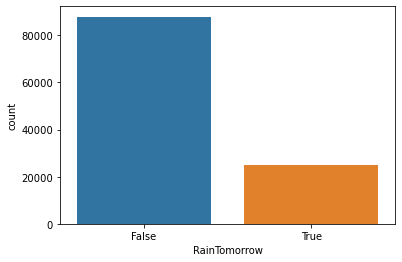

In [142]:
sns.countplot(df['RainTomorrow'])

**Findings after analyzing target variable**

- It has 2 unique values **True** and **False**
- There are **87906** entries for **False**
- There are **25019** entries for **True**
- We can conclude from the barplot that the number of False entries is significantly larger that number of True entries.

### Checking for Outliers

Text(0, 0.5, 'WindSpeed3pm')

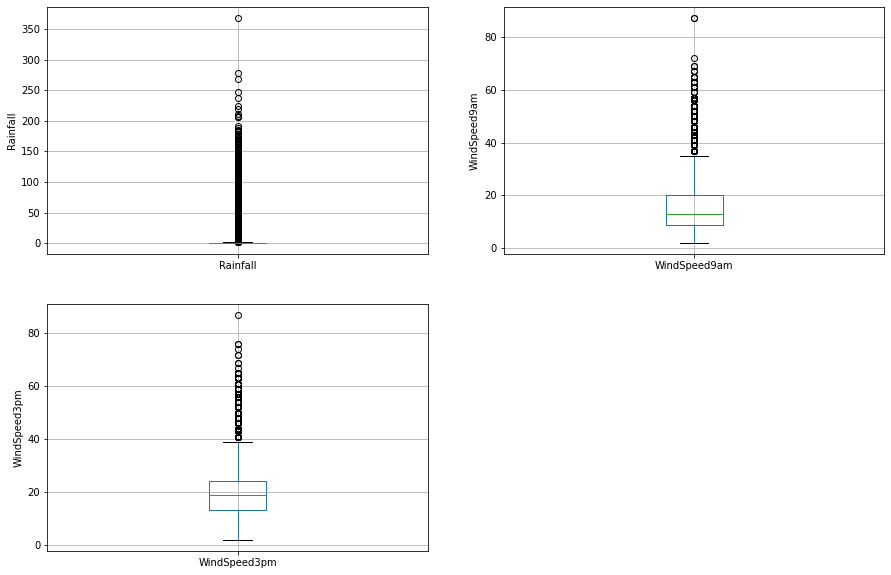

In [143]:
plt.figure(figsize=(15,10))


plt.subplot(2, 2, 1)
fig = df.boxplot(column='Rainfall')
fig.set_title('')
fig.set_ylabel('Rainfall')


plt.subplot(2, 2, 2)
fig = df.boxplot(column='WindSpeed9am')
fig.set_title('')
fig.set_ylabel('WindSpeed9am')


plt.subplot(2, 2, 3)
fig = df.boxplot(column='WindSpeed3pm')
fig.set_title('')
fig.set_ylabel('WindSpeed3pm')

### Visualizations

#### Heatmap

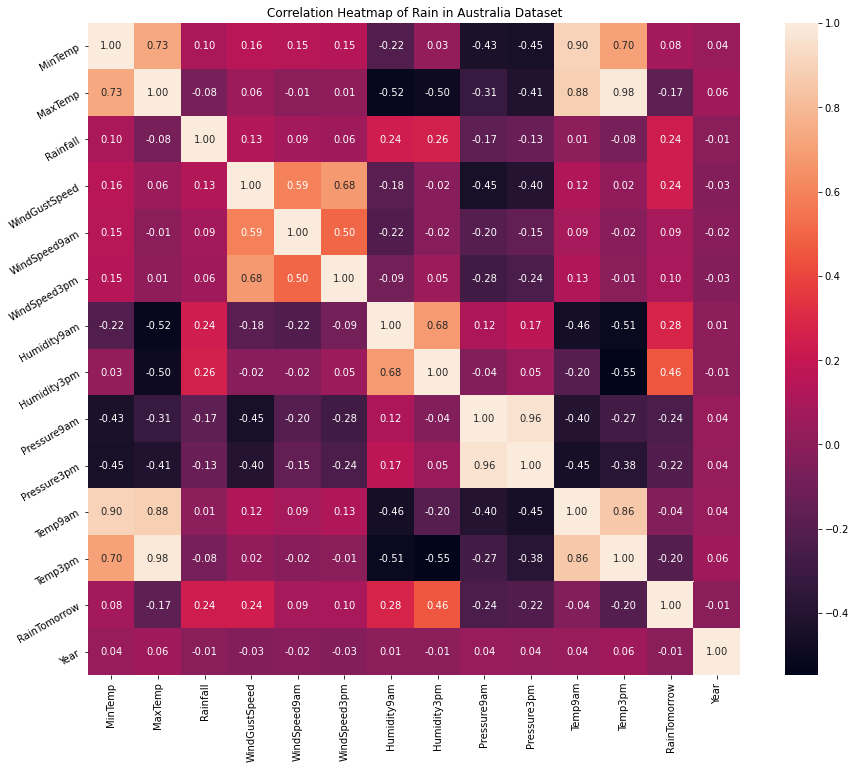

In [144]:
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Rain in Australia Dataset')
ax = sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

**Interpretation**

From the above correlation heat map, we can conclude that :-

- MinTemp and MaxTemp variables are highly positively correlated (correlation coefficient = 0.74).

- MinTemp and Temp3pm variables are also highly positively correlated (correlation coefficient = 0.71).

- MinTemp and Temp9am variables are strongly positively correlated (correlation coefficient = 0.90).

- MaxTemp and Temp9am variables are strongly positively correlated (correlation coefficient = 0.89).

- MaxTemp and Temp3pm variables are also strongly positively correlated (correlation coefficient = 0.98).

- WindGustSpeed and WindSpeed3pm variables are highly positively correlated (correlation coefficient = 0.69).

- Pressure9am and Pressure3pm variables are strongly positively correlated (correlation coefficient = 0.96).

- Temp9am and Temp3pm variables are strongly positively correlated (correlation coefficient = 0.86).

In [145]:
high_corr = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm']

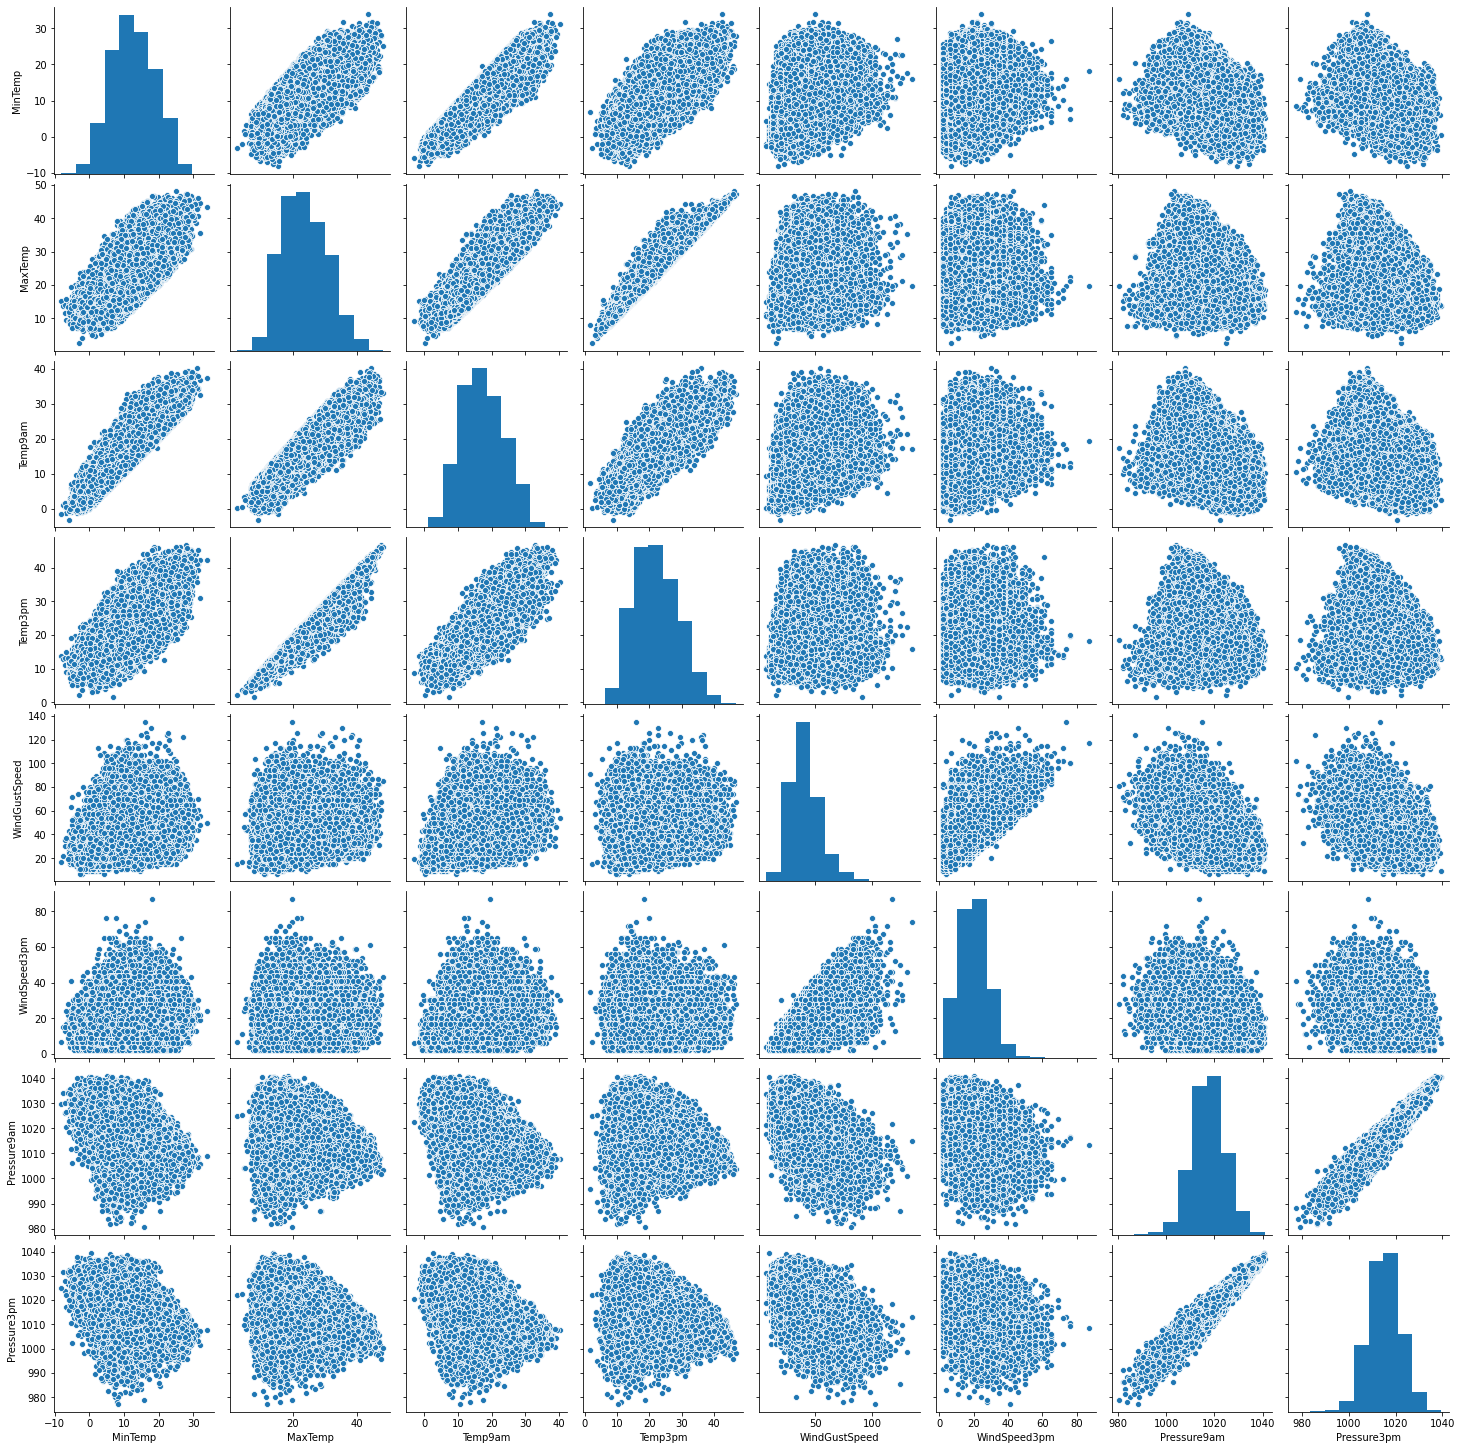

In [146]:
sns.pairplot(df[high_corr])
plt.show()

### Handle Outliers in Numerical Variables

We will use **top-coding approach** to cap maximum values and remove outliers from the above variables.

In [147]:
def max_value(df3, variable, top):
    return np.where(df3[variable]>top, top, df3[variable])

df['Rainfall'] = max_value(df, 'Rainfall', 3.2)
df['WindSpeed9am'] = max_value(df, 'WindSpeed9am', 55)
df['WindSpeed3pm'] = max_value(df, 'WindSpeed3pm', 57)

Text(0, 0.5, 'Rainfall')

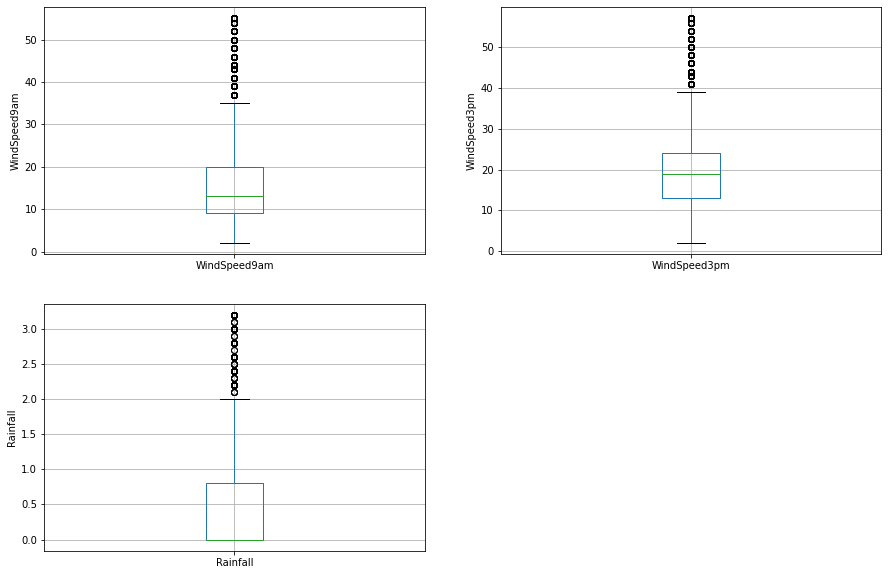

In [148]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
fig = df.boxplot(column='WindSpeed9am')
fig.set_title('')
fig.set_ylabel('WindSpeed9am')

plt.subplot(2, 2, 2)
fig = df.boxplot(column='WindSpeed3pm')
fig.set_title('')
fig.set_ylabel('WindSpeed3pm')

plt.subplot(2, 2, 3)
fig = df.boxplot(column='Rainfall')
fig.set_title('')
fig.set_ylabel('Rainfall')

**We conclude from the boxplot that there are no more outliers in the dataset.**

### Handling Categorical Data

In [149]:
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=['RainToday'])
df = encoder.fit_transform(df)

In [150]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday_0,RainToday_1,RainTomorrow,Year
6190,Albury,12.6,32.4,0.0,W,43.0,E,W,4.0,19.0,49.0,17.0,1012.9,1010.1,21.5,31.2,0,1,False,2008
6191,Albury,16.1,38.9,0.0,W,57.0,E,W,6.0,30.0,34.0,12.0,1007.0,1002.7,25.2,38.4,0,1,False,2009
6192,Albury,20.4,40.7,0.0,N,37.0,E,NNE,7.0,13.0,45.0,15.0,1014.9,1011.6,28.2,39.2,0,1,False,2009
6194,Albury,11.0,30.2,0.0,SSE,24.0,E,SSE,7.0,11.0,54.0,20.0,1017.0,1014.7,17.6,28.8,0,1,False,2009
6195,Albury,7.8,21.7,0.0,WSW,31.0,E,NW,6.0,19.0,72.0,37.0,1020.4,1016.5,12.9,21.2,0,1,False,2009


**We can see that two additional variables RainToday_0 and RainToday_1 are created from RainToday variable.**

Now we will encode the **Location**,**WindGustDir**, **WindDir3pm** and **WindDir9am** variable using One Hot Encoding.

In [151]:
categorical = ['Location','WindGustDir', 'WindDir3pm', 'WindDir9am']
df_new = pd.concat([df, pd.get_dummies(df[categorical], columns=categorical)], axis=1)

In [152]:
df_new.columns.values

array(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday_0', 'RainToday_1',
       'RainTomorrow', 'Year', 'Location_Adelaide', 'Location_Albury',
       'Location_AliceSprings', 'Location_BadgerysCreek',
       'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane',
       'Location_Cairns', 'Location_Canberra', 'Location_Cobar',
       'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin',
       'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine',
       'Location_Launceston', 'Location_Melbourne',
       'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree',
       'Location_MountGambier', 'Location_Nhil', 'Location_NorahHead',
       'Location_NorfolkIsland', 'Location_Nuriootpa',
       'Location_PearceRAAF', 'Location_Perth', 'Location_PerthAi

In [153]:
df_new = df_new.drop(columns=['Location','WindGustDir','WindDir3pm','WindDir9am'],axis=1)

In [154]:
df_new.shape

(112925, 108)

In [165]:
for i in df_new:
    if df_new[i].dtypes == "uint8":
        df_new[i]=df_new[i].astype("int64")

In [166]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112925 entries, 6190 to 142192
Columns: 108 entries, MinTemp to WindDir9am_WSW
dtypes: bool(1), float64(12), int64(95)
memory usage: 93.2 MB


### Load a Dataframe into BigQuery

In [167]:
import pandas_gbq

pandas_gbq.to_gbq(
    df_new, 'australia_weather.preprocessed_new', project_id='thematic-flash-266714', if_exists='replace',
)


0it [00:00, ?it/s]
1it [00:46, 46.45s/it]
